In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=828800901e37b44ded63376ea9dcb7d39a49dd2999c52642db45368216c0c0ae
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from sklearn.datasets import fetch_20newsgroups
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [ ]:
spark = SparkSession.builder \
    .appName("Cluster1") \
    .getOrCreate()

In [ ]:
data = fetch_20newsgroups()

+--------------------+------+
|                text|target|
+--------------------+------+
|From: lerxst@wam....|     7|
|From: guykuo@cars...|     4|
|From: twillis@ec....|     4|
|From: jgreen@ambe...|     1|
|From: jcm@head-cf...|    14|
+--------------------+------+
only showing top 5 rows

+------+-----+
|target|count|
+------+-----+
|     0|  480|
|     1|  584|
|     2|  591|
|     3|  590|
|     4|  578|
|     5|  593|
|     6|  585|
|     7|  594|
|     8|  598|
|     9|  597|
|    10|  600|
|    11|  595|
|    12|  591|
|    13|  594|
|    14|  593|
|    15|  599|
|    16|  546|
|    17|  564|
|    18|  465|
|    19|  377|
+------+-----+

+-------+--------------------+-----------------+
|summary|                text|           target|
+-------+--------------------+-----------------+
|  count|               11314|            11314|
|   mean|                NULL| 9.29299982322786|
| stddev|                NULL|5.562719106678614|
|    min| cs.utexas.edu!ge...|                0|
|

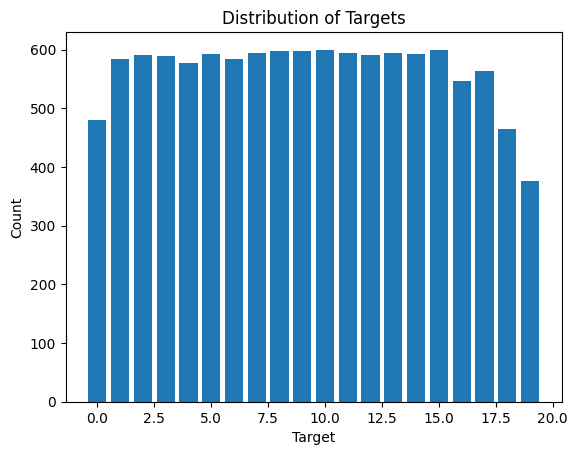

In [ ]:
df = pd.DataFrame({'text': data.data, 'target': data.target})
spark_df = spark.createDataFrame(df)

spark_df.show(5)
target_distribution = spark_df.groupBy("target").count().orderBy("target")
target_distribution.show()

basic_stats = spark_df.describe()
basic_stats.show()

target_distribution_pd = target_distribution.toPandas()
plt.bar(target_distribution_pd['target'], target_distribution_pd['count'])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Targets')
plt.show()

In [ ]:
spark_df = spark.createDataFrame(df)

# Define pipeline stages
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

# Fit the pipeline to the data (use spark_df instead of df)
model = pipeline.fit(spark_df)

# Transform the data (use spark_df instead of df)
transformed_df = model.transform(spark_df)

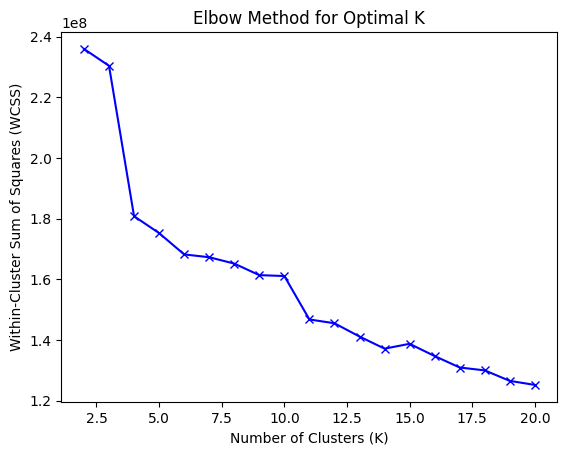

In [ ]:
k_values = range(2, 21)  # Range of K values to try
wcss_values = []

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1)
    kmeans_model = kmeans.fit(transformed_df)
    wcss_values.append(kmeans_model.summary.trainingCost)

# Plot the elbow method to find the optimal number of clusters for K-means
plt.plot(k_values, wcss_values, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [ ]:
optimal_k = 13

kmeans = KMeans().setK(optimal_k).setSeed(1)
kmeans_model = kmeans.fit(transformed_df)
clustered_df = kmeans_model.transform(transformed_df)

clustered_df.show()

+--------------------+------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|target|               words|      filtered_words|         rawFeatures|            features|prediction|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+----------+
|From: lerxst@wam....|     7|[from:, lerxst@wa...|[from:, lerxst@wa...|(262144,[528,3924...|(262144,[528,3924...|         0|
|From: guykuo@cars...|     4|[from:, guykuo@ca...|[from:, guykuo@ca...|(262144,[3415,391...|(262144,[3415,391...|         0|
|From: twillis@ec....|     4|[from:, twillis@e...|[from:, twillis@e...|(262144,[4254,590...|(262144,[4254,590...|         0|
|From: jgreen@ambe...|     1|[from:, jgreen@am...|[from:, jgreen@am...|(262144,[6193,927...|(262144,[6193,927...|         0|
|From: jcm@head-cf...|    14|[from:, jcm@head-...|[from:, jcm@head-...|(262144,[991,2262...|(262144,[991,2262...|         0|


In [ ]:
from sklearn.cluster import AgglomerativeClustering

features_array = transformed_df.select('features').rdd.map(lambda x: x[0]).collect()

# Instantiate the AgglomerativeClustering model with the desired number of clusters
num_clusters = 3
hierarchical_clustering = AgglomerativeClustering(n_clusters=num_clusters)

# Fit the model to your data
cluster_labels = hierarchical_clustering.fit_predict(features_array)

clustered_df_hierarchical = transformed_df.withColumn('hierarchical_cluster', F.array([F.lit(x) for x in cluster_labels]))
clustered_df_hierarchical.show()